In [1]:
import os

src_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
os.chdir(src_path)

from src.seacast_tools import noise_generator
from weatherbenchX.metrics import deterministic
from weatherbenchX.metrics import base as metrics_base
from weatherbenchX import aggregation
from matplotlib.colors import Normalize
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from neural_lam.weather_dataset import WeatherDataset
from neural_lam import constants

In [2]:
def flatten_to_2d(datos, mask, shape=(300, 300)):
    mask = mask.flatten()
    temperature_map = np.full_like(mask, np.nan, dtype=float)

    j = 0
    for i in range(len(mask)):
        if mask[i] == 1:
            temperature_map[i] = datos[j]
            j += 1

    return temperature_map.reshape(shape)

def plot_temperature_map(temperature_map, cmap="inferno"):
    plt.figure(figsize=(6, 6))
    ax = plt.gca()

    norm = Normalize(vmin=np.nanmin(temperature_map), vmax=np.nanmax(temperature_map))

    im = plt.imshow(temperature_map, cmap=cmap, origin='lower', norm=norm)


    plt.colorbar(im, label=r"SST (K)")


    plt.show()

sea_mask = np.load(r"data\atlantic\static\sea_mask.npy")

In [3]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize
import numpy as np

def plot_noise_maps_transposed(noises_dict, mask, shape=(300, 300), cmap="inferno", colorbar_label="Ruido añadido (K)", name_file="ruido"):
    def flatten_to_2d(data, mask, shape):
        flat_mask = mask.flatten()
        temp_map = np.full(flat_mask.shape, np.nan, dtype=float)
        j = 0
        for i in range(len(flat_mask)):
            if flat_mask[i] == 1:
                temp_map[i] = data[j]
                j += 1
        return temp_map.reshape(shape)

    def generate_maps(noise_array):
        return [flatten_to_2d(noise_array[i], mask, shape) for i in range(noise_array.shape[0])]

    maps_by_noise = {name: generate_maps(arr) for name, arr in noises_dict.items()}

    noise_names = list(maps_by_noise.keys())
    n_cols = len(noise_names)
    n_rows = len(next(iter(maps_by_noise.values())))

    all_values = np.concatenate([
        map_2d[~np.isnan(map_2d)]
        for maps in maps_by_noise.values()
        for map_2d in maps
    ])
    vmin, vmax = all_values.min(), all_values.max()

    fig = plt.figure(figsize=(4.5 * n_cols + 2, 4.5 * n_rows))
    spec = GridSpec(n_rows, n_cols + 1, width_ratios=[1]*n_cols + [0.05], wspace=0.2)

    axes = []
    for i in range(n_rows):
        row_axes = []
        for j in range(n_cols):
            ax = fig.add_subplot(spec[i, j])
            row_axes.append(ax)
        axes.append(row_axes)

    im = None
    for row_idx in range(n_rows):
        for col_idx, name in enumerate(noise_names):
            ax = axes[row_idx][col_idx]
            ax.set_xticks([])
            ax.set_yticks([])
            maps = maps_by_noise[name]
            if row_idx < len(maps):
                im = ax.imshow(maps[row_idx], cmap=cmap, origin='lower',
                               norm=Normalize(vmin=vmin, vmax=vmax))
            ax.set_frame_on(True)

            if row_idx == 0:
                ax.set_title(name, fontsize=20)

        fig.text(0.05, 1 - (row_idx + 0.5) / n_rows, f"Estado inicial {row_idx + 1}", va='center', ha='right',
                 fontsize=20, fontweight='bold')

    cbar_ax = fig.add_subplot(spec[:, -1])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label(colorbar_label, fontsize=20)

    plt.tight_layout(rect=[0.1, 0, 0.95, 1])
    plt.savefig(f"metrics/initial_state_noise/{name_file}_noise_maps.svg", format="svg", bbox_inches='tight')
    plt.show()

In [4]:
def plot_single_row_noise_comparison(noises_dict, mask, shape=(300, 300), cmap="inferno", colorbar_label="Ruido añadido (K)", name_file="ruido"):
    def flatten_to_2d(data, mask, shape):
        flat_mask = mask.flatten()
        temp_map = np.full(flat_mask.shape, np.nan, dtype=float)
        j = 0
        for i in range(len(flat_mask)):
            if flat_mask[i] == 1:
                temp_map[i] = data[j]
                j += 1
        return temp_map.reshape(shape)

    maps_by_noise = {name: flatten_to_2d(arr[0], mask, shape) for name, arr in noises_dict.items()}

    noise_names = list(maps_by_noise.keys())
    n_cols = len(noise_names)

    all_values = np.concatenate([
        map_2d[~np.isnan(map_2d)]
        for map_2d in maps_by_noise.values()
    ])
    vmin, vmax = all_values.min(), all_values.max()

    fig = plt.figure(figsize=(5 * n_cols, 5))
    spec = GridSpec(1, n_cols + 1, width_ratios=[1]*n_cols + [0.05], wspace=0.3)

    axes = []
    for i in range(n_cols):
        ax = fig.add_subplot(spec[0, i])
        axes.append(ax)

    im = None
    for idx, (name, map_2d) in enumerate(maps_by_noise.items()):
        ax = axes[idx]
        im = ax.imshow(map_2d, cmap=cmap, origin='lower',
                       norm=Normalize(vmin=vmin, vmax=vmax))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(name, fontsize=14)

    cbar_ax = fig.add_subplot(spec[0, -1])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label(colorbar_label, fontsize=14)

    plt.tight_layout(rect=[0, 0, 0.95, 1])
    plt.savefig(f"metrics/initial_state_noise/{name_file}_noise_comparison.svg", format="svg", bbox_inches='tight')
    plt.show()

In [5]:
def plot_single_noise_histograms(noises_dict, mask, bins=100, name_file="ruido"):
    mask_flat = mask.flatten()

    plt.figure(figsize=(10, 6))

    for name, noise_array in noises_dict.items():
        one_sample = noise_array[0]
        data = np.full(mask_flat.shape, np.nan, dtype=float)
        j = 0
        for k in range(len(mask_flat)):
            if mask_flat[k] == 1:
                data[k] = one_sample[j]
                j += 1

        values = data[~np.isnan(data)]
        plt.hist(values, bins=bins, alpha=0.6, label=name, density=True)

    plt.xlabel("Ruido añadido (K)")
    plt.ylabel("Densidad")

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"metrics/initial_state_noise/{name_file}_noise_histograms.svg", format="svg", bbox_inches='tight')
    plt.show()

In [6]:
dataset_name = "atlantic"
data_subset = "reanalysis"
forcing_prefix = "forcing"
split = "test"
pred_length = (constants.SAMPLE_LEN[split] // 1) - 2


ds_clean = WeatherDataset(
    dataset_name=dataset_name,
    split=split,
    noise=None,
    data_subset=data_subset,
    forcing_prefix=forcing_prefix,
    pred_length=pred_length,
    standardize=False,
)

ds_noisy = WeatherDataset(
    dataset_name=dataset_name,
    split=split,
    noise="gaussian",
    data_subset=data_subset,
    forcing_prefix=forcing_prefix,
    pred_length=pred_length,
    standardize=False,
)

idx = 0
init_clean, target_clean, _ = ds_clean[idx]
init_noisy, target_noisy, _ = ds_noisy[idx]


init_clean_np = init_clean.squeeze(-1).cpu().numpy()
init_noisy_np = init_noisy.squeeze(-1).cpu().numpy()

diff_init = init_noisy_np - init_clean_np

#np.save("data/noise_example/gaussian_05", diff_init)


### Comparaciones ruido Perlin

0.3930664
0.53118896


C:\Users\Alejandro\AppData\Local\Temp\ipykernel_18788\3424682303.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.1, 0, 0.95, 1])


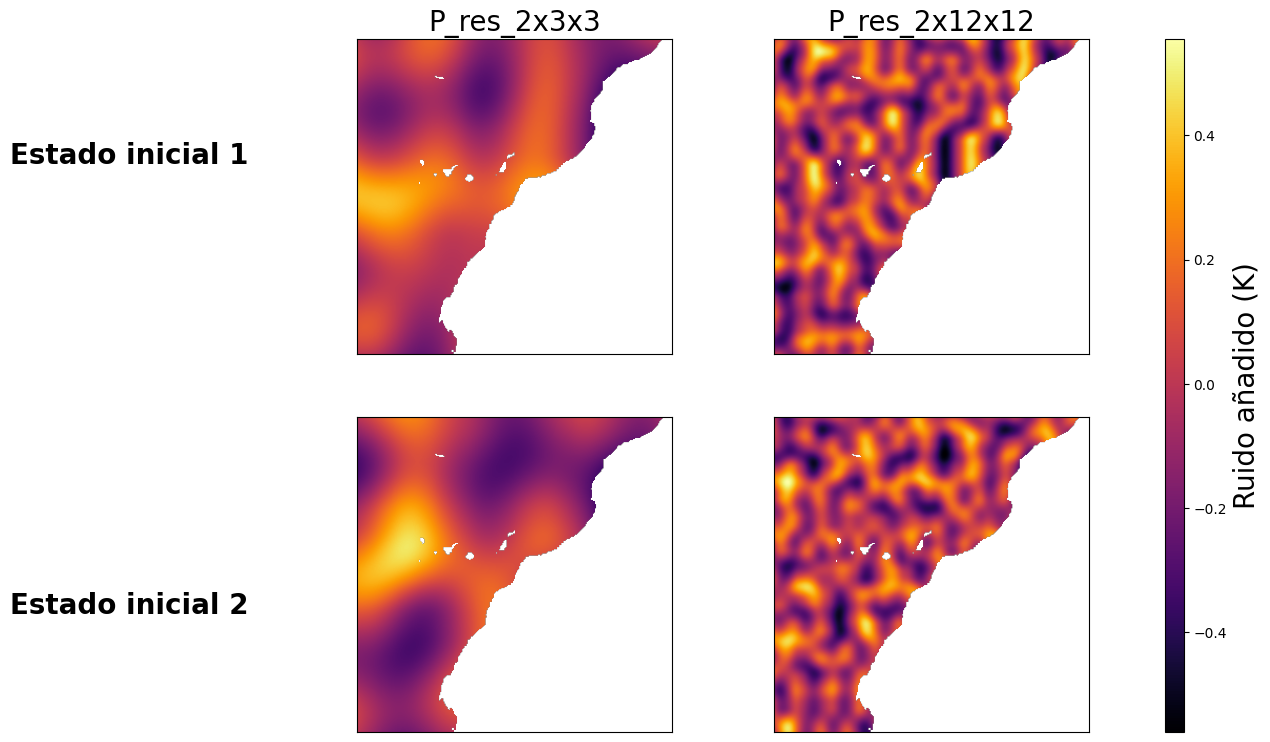

In [7]:
perlin_12_12_init = np.load("data/noise_example/perlin_12_12.npy")
perlin_3_3_init = np.load("data/noise_example/perlin_3_3.npy")

noises = {
    "P_res_2x3x3": perlin_3_3_init,
    "P_res_2x12x12": perlin_12_12_init,
}

print(np.max(perlin_3_3_init[0]))
print(np.max(perlin_12_12_init[0]))

plot_noise_maps_transposed(noises, sea_mask, shape=(300,300), cmap="inferno", colorbar_label="Ruido añadido (K)", name_file="perlin")

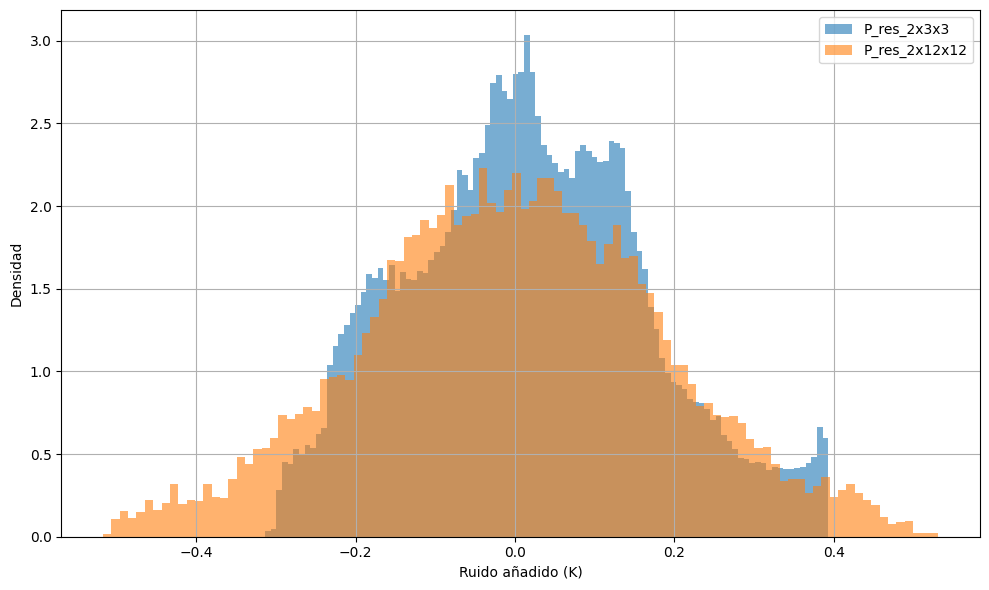

In [8]:
plot_single_noise_histograms(noises, sea_mask, bins=100, name_file="perlin")

C:\Users\Alejandro\AppData\Local\Temp\ipykernel_18788\2759088414.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.95, 1])


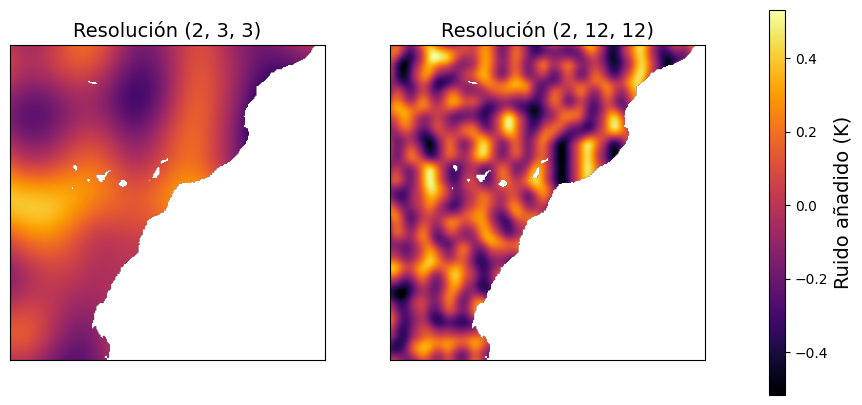

In [9]:
noises = {
    "Resolución (2, 3, 3)": perlin_3_3_init,
    "Resolución (2, 12, 12)": perlin_12_12_init,
}

plot_single_row_noise_comparison(noises, sea_mask, shape=(300,300), cmap="inferno", colorbar_label="Ruido añadido (K)", name_file="perlin")

### Pruebas Gaussiano

C:\Users\Alejandro\AppData\Local\Temp\ipykernel_18788\3424682303.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.1, 0, 0.95, 1])


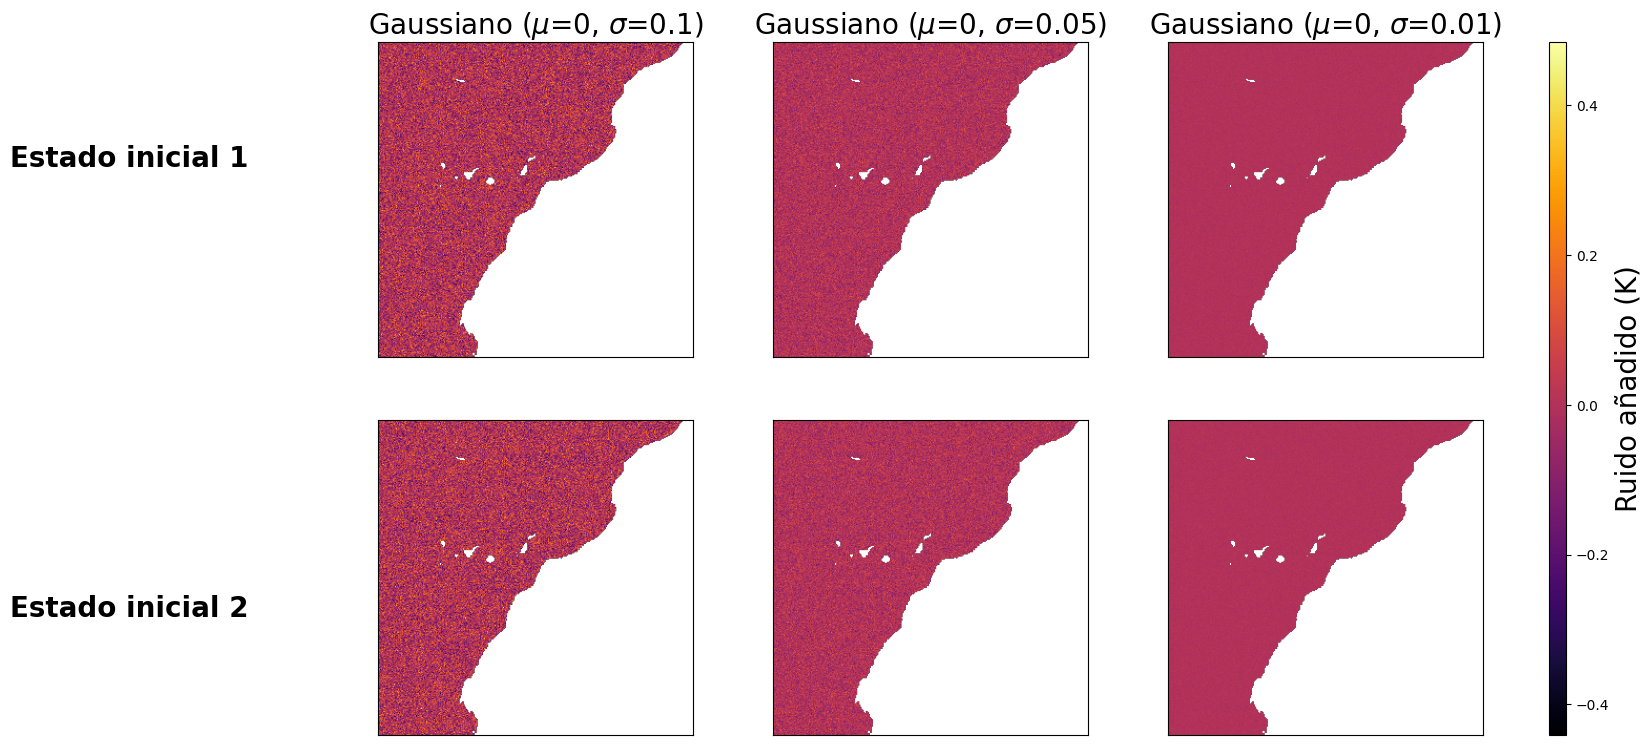

In [10]:
gaussian_01 = np.load("data/noise_example/gaussian_01.npy")
gaussian_005 = np.load("data/noise_example/gaussian_005.npy")
gaussian_001 = np.load("data/noise_example/gaussian_001.npy")

noises = {
    "Gaussiano ($\mu$=0, $\sigma$=0.1)": gaussian_01,
    "Gaussiano ($\mu$=0, $\sigma$=0.05)": gaussian_005,
    "Gaussiano ($\mu$=0, $\sigma$=0.01)": gaussian_001
}

plot_noise_maps_transposed(noises, sea_mask, shape=(300,300), cmap="inferno", colorbar_label="Ruido añadido (K)", name_file="gaussian")

C:\Users\Alejandro\AppData\Local\Temp\ipykernel_18788\2759088414.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.95, 1])


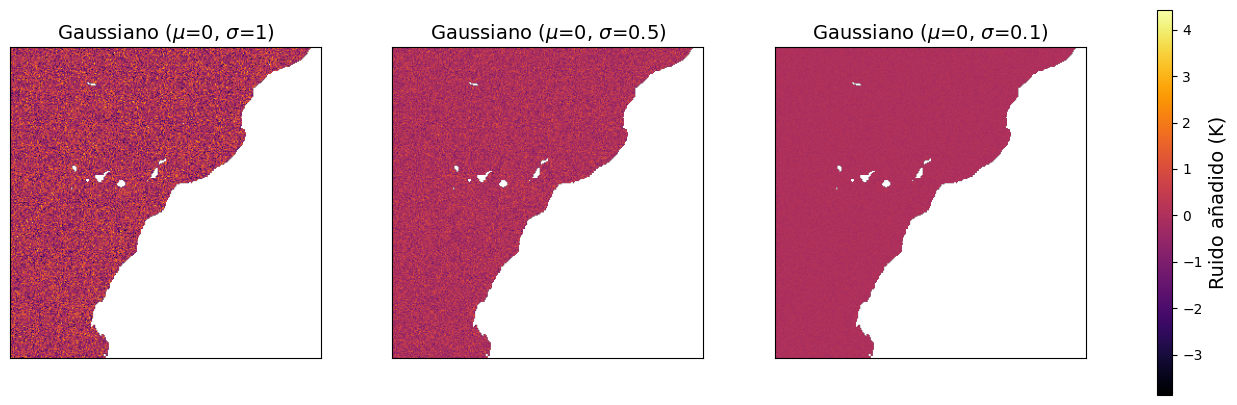

In [11]:
gaussian_1 = np.load("data/noise_example/gaussian_1.npy")
gaussian_01 = np.load("data/noise_example/gaussian_01.npy")
gaussian_05 = np.load("data/noise_example/gaussian_05.npy")

noises = {
    "Gaussiano ($\mu$=0, $\sigma$=1)": gaussian_1,
    "Gaussiano ($\mu$=0, $\sigma$=0.5)": gaussian_05,
    "Gaussiano ($\mu$=0, $\sigma$=0.1)": gaussian_01
}

plot_single_row_noise_comparison(noises, sea_mask, shape=(300,300), cmap="inferno", colorbar_label="Ruido añadido (K)", name_file="gaussian")

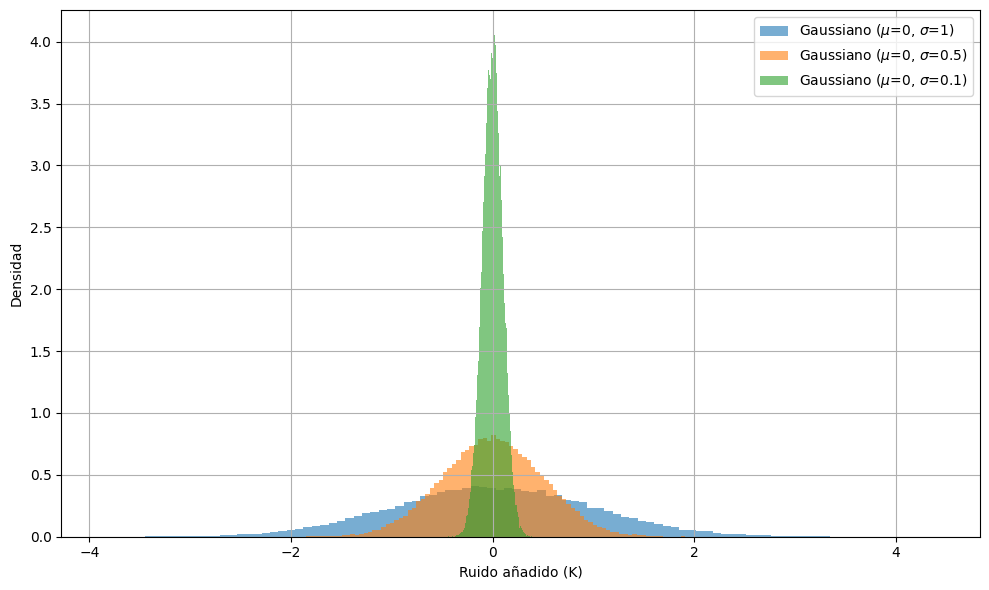

In [12]:
plot_single_noise_histograms(noises, sea_mask, bins=100, name_file="gaussian")

### Pruebas Perlin fractal

In [13]:
perlin_fractal_15_15 = np.load("data/noise_example/perlin_fractal_15_15.npy")
perlin_fractal_15_15_005 = np.load("data/noise_example/perlin_fractal_15_15_005.npy")
perlin_fractal_15_15_f_f = np.load("data/noise_example/perlin_fractal_15_15_f_f.npy")
perlin_fractal_5_5 = np.load("data/noise_example/perlin_fractal_5_5.npy")
perlin_fractal_15_15_04 = np.load("data/noise_example/perlin_fractal_15_15_04.npy")


noises = {
    "PF_res_15x15": perlin_fractal_15_15,
    r"PF_res_15x15 ($\alpha$=0.05)": perlin_fractal_15_15_005,
    "PF_res_15x15_without_tileable": perlin_fractal_15_15_f_f,
    "Perlin Fractal 5x5": perlin_fractal_5_5,
    r"Perlin Fractal 15x15($\alpha$=0.4)": perlin_fractal_15_15_04,
}

C:\Users\Alejandro\AppData\Local\Temp\ipykernel_18788\3424682303.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.1, 0, 0.95, 1])


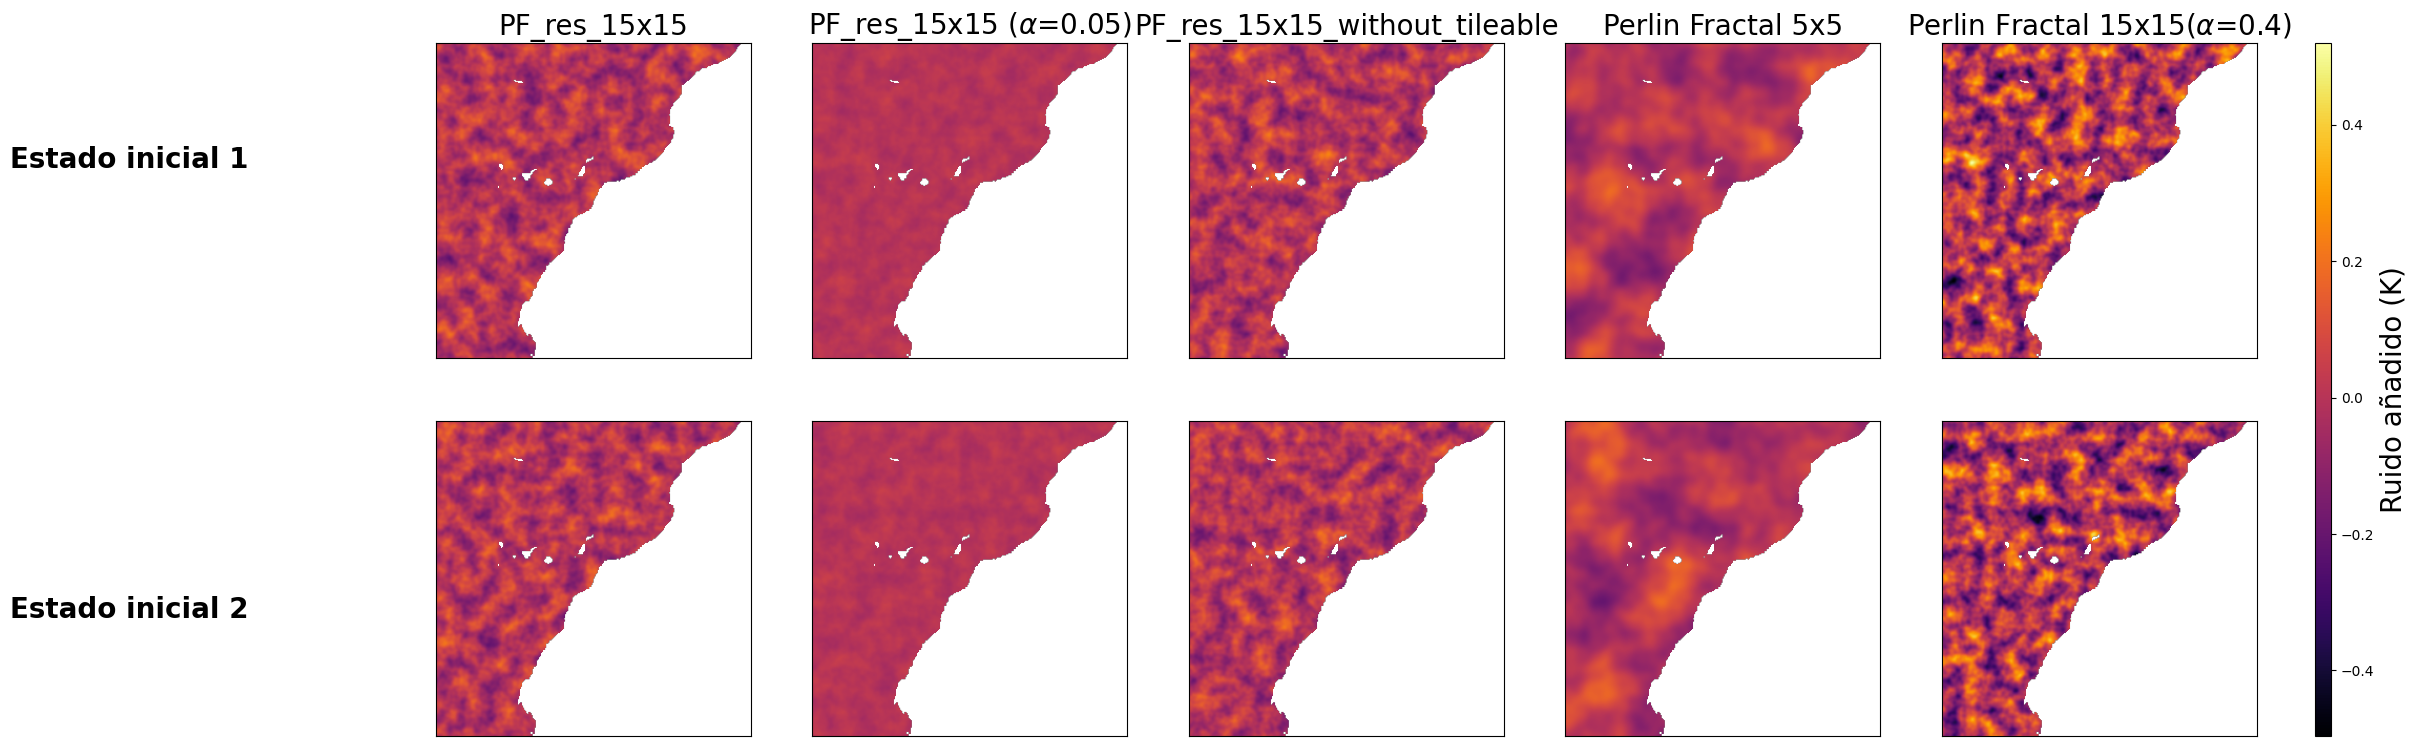

In [14]:
plot_noise_maps_transposed(noises, sea_mask, shape=(300,300), cmap="inferno", colorbar_label="Ruido añadido (K)", name_file="perlin_fractal")

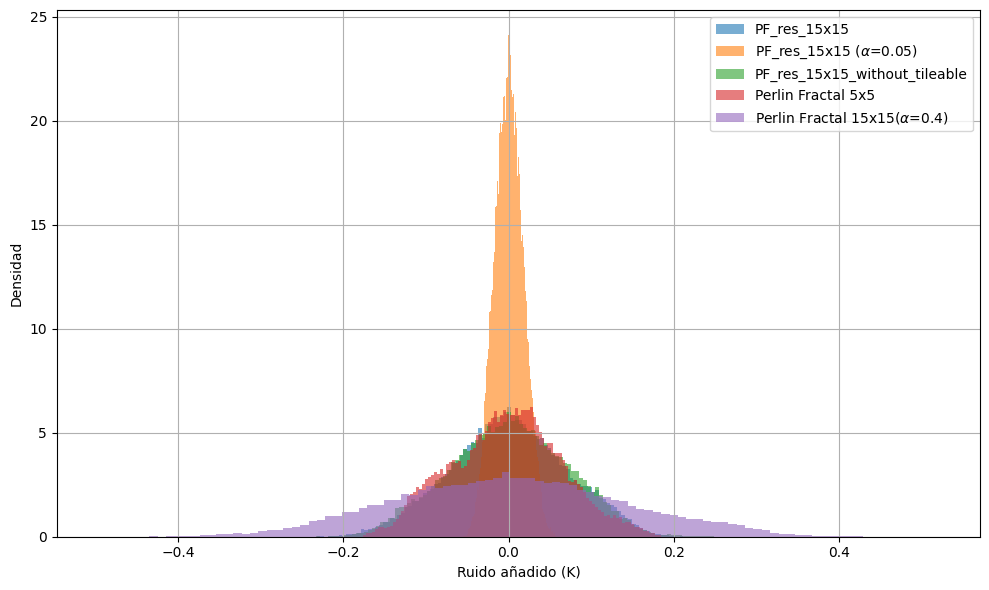

In [15]:
plot_single_noise_histograms(noises, sea_mask, bins=100, name_file="perlin_fractal")

In [16]:
perlin_fractal_15_15 = np.load("data/noise_example/perlin_fractal_15_15.npy")
perlin_fractal_5_5 = np.load("data/noise_example/perlin_fractal_5_5.npy")


noises = {
    r"Resolución (15, 15) $\alpha$=0.2": perlin_fractal_15_15,
    r"Resolución (5, 5) $\alpha$=0.2": perlin_fractal_5_5
}

C:\Users\Alejandro\AppData\Local\Temp\ipykernel_18788\2759088414.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.95, 1])


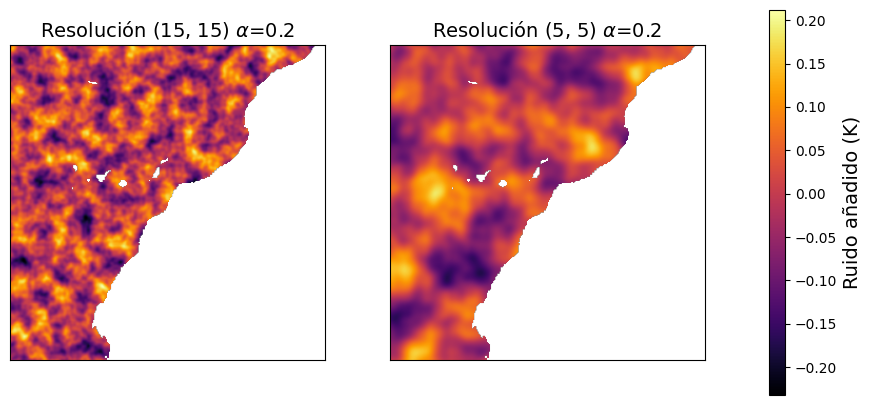

In [17]:
plot_single_row_noise_comparison(noises, sea_mask, shape=(300,300), cmap="inferno", colorbar_label="Ruido añadido (K)", name_file="perlin_fractal")